# Part 4: Learn how to play Tic-Tac-Toe with reinforcement learning

Implement simple tictactoe game in Python with text-based output and learn how to play it using the Minmax algorithm, tabular Q-learning and deep Q-learning with dense neural networks using a dual network architecture, dueling network and (prioritised) experience replay. The neural networks are implemented using Keras and TensorFlow. I took inspiration and validated the results with Casten Friedrich's tutorial on implementing reinforcement agents for tictactoe https://github.com/fcarsten/tic-tac-toe.

See the blog post https://kunkelalexander.github.io/blog/computers-learning-tic-tac-toe-deep-q/ for more information. 

# Setup

Include dependencies, set up plot style and define a few helper functions for plotting. 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns

import io
import random
import os
import re
import multiprocessing

# Get total number of logical CPUs
n_cores = multiprocessing.cpu_count()

# Let TensorFlow use all available threads
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(n_cores)
os.environ["TF_NUM_INTEROP_THREADS"] = "2"  # can be 1–4, experiment for best performance
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # optional: suppress TF logging


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image

from src.tictactoe import TicTacToe
from src.game_manager import GameManager
from src.training_manager import TrainingManager
from src.agent_tabular_q import TabularQAgent
from src.agent_deep_q import DeepQAgent
from src.agent_random import RandomAgent
from src.agent_minmax import MinMaxAgent
from src.gui import ascii_gui

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed(42)

# Force TensorFlow into deterministic op mode (TF 2.x)
tf.config.experimental.enable_op_determinism()

# Output resolution
DPI = 400


# Get 3 colors from the magma colormap (evenly spaced)
magma_cmap = cm.get_cmap('magma')
colors = [magma_cmap(i) for i in [0.2, 0.5, 0.8]]  # Dark to light
p2_color   = colors[0]
p1_color   = colors[1]
draw_color   = colors[2]

def plot_neon(results_dict, title, colors, labels, filename):
    agents = results_dict["agents"]
    results = results_dict["results"]

    episodes = results["evaluation_episodes"]
    metrics = results["metrics"]

    num_episodes = len(episodes)
    num_agents = len(agents)

    # Stack: [agent1_win, agent2_win, ..., draw] (shape: episodes x (n_agents + 1))
    victory_rates = np.column_stack([metrics[f"victory_rate_{agent.name}"] for agent in agents])
    draw_rates = np.array(metrics["draw_rate"])
    all_rates = np.hstack([victory_rates, draw_rates.reshape(-1, 1)])


    # Create figure
    fig, ax = plt.subplots(figsize=(5, 3), dpi=DPI)
    plt.axis("off")

    x = np.arange(1, num_episodes+1)
    bottom = np.zeros(num_episodes)

    for i in range(num_agents + 1):
        bar = ax.bar(
            x+0.5, all_rates[:, i],
            bottom=bottom,
            color=colors[i],
            edgecolor='black',
            label=labels[i],
            width=1.0
        )

        # Add percentage text
        for rect, rate in zip(bar, all_rates[:, i]):
            if rate > 0.05:  # Skip tiny percentages
                height = rect.get_height()
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + height / 2,
                    f"{int(rate * 100)}%",
                    ha='center',
                    va='center',
                    fontsize=5,
                    color='white',
                    fontweight="bold"
                )
        bottom += all_rates[:, i]

    # Remove y-axis and spines
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.tick_params(axis='x', colors='white')

    # Title and x-label
    ax.set_title(title,  color='black', fontweight="bold")
    ax.set_xlabel("Episode", color='white')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=8,
          ncol=3, fancybox=True, shadow=True)


    plt.tight_layout()
    plt.savefig(filename, dpi=DPI, bbox_inches='tight')
    plt.show()
    plt.close()

def compare_training_runs(runs_outputs, run_names, colors, labels, filename, title="Training Run Comparison"):
    """
    Plots a stacked bar chart comparing the final evaluation snapshot of multiple training runs.

    Parameters:
        runs_outputs (list of dicts): Each item is a dict with keys 'agents' and 'results'
        run_names (list of str): Names of the training runs, used as x-axis labels
        colors (list): Colors for bars (one per agent + draw)
        labels (list): Labels (e.g. ["Agent A", "Agent B", "Draw"])
        filename (str): Output file path to save the figure
        title (str): Title of the plot
    """
    num_runs = len(runs_outputs)
    num_categories = len(labels)

    all_last_rates = []

    for run in runs_outputs:
        agents = run["agents"]
        metrics = run["results"]["metrics"]

        last_victory = [metrics[f"victory_rate_{agent.name}"][-1] for agent in agents]
        last_draw = metrics["draw_rate"][-1]

        all_last_rates.append(np.array(last_victory + [last_draw]))

    all_last_rates = np.array(all_last_rates)  # shape: (num_runs, num_categories)


    # Plot setup
    fig, ax = plt.subplots(figsize=(5, 3), dpi=DPI)

    x = np.arange(num_runs)  # Run positions
    bar_width = 0.8
    bottoms = np.zeros(num_runs)

    for i in range(num_categories):
        bar = ax.bar(
            x,
            all_last_rates[:, i],
            bottom=bottoms,
            color=colors[i],
            edgecolor='black',
            label=labels[i],
            width=bar_width
        )

        # Add percentage text
        for rect, rate in zip(bar, all_last_rates[:, i]):
            if rate > 0.05:
                height = rect.get_height()
                ax.text(
                    rect.get_x() + rect.get_width() / 2,
                    rect.get_y() + height / 2,
                    f"{int(rate * 100)}%",
                    ha='center',
                    va='center',
                    fontsize=5,
                    color='white',
                    fontweight="bold"
                )
        bottoms += all_last_rates[:, i]

    # Axes and labels
    ax.set_xticks(x)
    ax.set_xticklabels(run_names, rotation=0, color='black', fontsize=8)
    # Optional: create space below bars for labels
    ax.tick_params(axis='x', which='both', length=0)

    ax.set_yticks([])
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)  # or True if you want a line

    ax.set_title(title, color='black', fontweight="bold")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=8,
              ncol=3, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(filename, dpi=DPI, bbox_inches='tight')
    plt.show()
    plt.close()


class GifRecorder:
    def __init__(self, board_size, agent_symbols=None, labels=None):
        self.frames = []
        self.board_size = board_size
        self.agent_symbols = agent_symbols or {1: "X", 2: "◯"}
        self.labels = labels or ["P1\nwins", "P2\nwins", "Draw"]
        self.cmap = cm.get_cmap('magma')
        self.current_game = 1
        self.new_game_flag = True
        self.pending_annotation = None  # (text, color)

    def record_frame(self, board, agent_id=None, events=None, game_over=False):
        fig, ax = plt.subplots(figsize=(5, 3), dpi=DPI)
        plt.style.use('classic')
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_xlim(-1.5, self.board_size)
        ax.set_ylim(0, self.board_size)

        # --- Game number ---
        ax.text(-0.85, self.board_size / 2 + 0.6,
                f"Game\n{self.current_game}",
                ha='center', va='center',
                fontsize=18, fontweight='bold',
                color='black', linespacing=1.8)

        # --- Win/Draw annotation ---
        if self.pending_annotation:
            text, color = self.pending_annotation
            ax.text(-0.85, self.board_size / 2 - 0.9,
                    text,
                    ha='center', va='center',
                    fontsize=18, fontweight='bold',
                    color=color)

        self.new_game_flag = False

        # --- Grid ---
        for x in range(1, self.board_size):
            ax.plot([x, x], [0, self.board_size], color='black', linewidth=2)
            ax.plot([0, self.board_size], [x, x], color='black', linewidth=2)

        # --- Symbols ---
        for y in range(self.board_size):
            for x in range(self.board_size):
                cell = board[y, x]
                if cell in self.agent_symbols:
                    symbol = self.agent_symbols[cell]
                    color_idx = 0.2 if cell == 1 else 0.8
                    color = p1_color if cell == 1 else p2_color

                    # Shadow
                    for dx, dy in [(-0.03, -0.03), (0.03, 0.03), (-0.03, 0.03), (0.03, -0.03)]:
                        ax.text(x + 0.5 + dx, self.board_size - y - 0.5 + dy,
                                symbol, ha='center', va='center',
                                fontsize=28, color='black', alpha=0.8, weight='bold')
                    # Main symbol
                    ax.text(x + 0.5, self.board_size - y - 0.5,
                            symbol, ha='center', va='center',
                            fontsize=28, color=color, weight='bold')

        # --- Save Frame ---
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.05, dpi=DPI)
        buf.seek(0)
        img = Image.open(buf).convert('RGB')
        self.frames.append(img)
        plt.close()

        # --- On Game Over: set up annotation and insert a pause frame ---
        if game_over:
            if (("VICTORY" in events) and (agent_id == 1)) or (("DEFEAT" in events) and (agent_id == 2)):
                result_text, color = self.labels[0], p1_color
            elif (("VICTORY" in events) and (agent_id == 2)) or (("DEFEAT" in events) and (agent_id == 1)):
                result_text, color = self.labels[1], p2_color
            elif "DRAW" in events:
                result_text, color = self.labels[2], draw_color
            else:
                raise ValueError("Game over but no corresponding event")

            self.pending_annotation = (result_text, color)

            # Show annotated final frame longer (e.g. 2 sec @ 5 fps)
            for _ in range(10):  # 10 frames = 2 sec @ 200 ms/frame
                self.record_frame(board)

            self.insert_pause_frame(seconds=1)
            self.current_game += 1
            self.new_game_flag = True
            self.pending_annotation = None


    def insert_pause_frame(self, seconds=1, fps=5):
        if not self.frames:
            return
        last = self.frames[-1]
        pause_frames = [last.copy() for _ in range(seconds * fps)]
        self.frames.extend(pause_frames)

    def save_gif(self, path, duration=200):
        if self.frames:
            self.frames[0].save(path,
                                save_all=True,
                                append_images=self.frames[1:],
                                duration=duration,
                                loop=0)

def make_gif_gui(recorder):
    def gif_gui(game, agent_id, events, game_over):
        recorder.record_frame(game.board, agent_id, events, game_over)
    return gif_gui

def plot_q_table(q, q_ref=None, start_index=0, max_states=None, xlabel="States ordered by # valid moves (9 → 1)", order = None, vmin=None, vmax=None):

    if not order:
        # 1. Depth: number of legal (finite) actions per state
        depth = np.isfinite(q_ref if q_ref is not None else q).sum(axis=1)

        # 2. Sort states by descending depth
        order = np.argsort(-depth)
        depth_sorted = depth[order]

        # 3. Filter out states with 0 legal actions
        valid_mask = depth_sorted > 0
        order = order[valid_mask]
        depth_sorted = depth_sorted[valid_mask]

        # 4. Apply start index and optional max_states filter
        order = order[start_index:]
        if max_states is not None:
            order = order[:max_states]

    q_sorted = q[order]  # (N_states, 9)

    # -----------------------------------------------------------
    # 1.  Make an HTML-ready 3 × 3 board
    # -----------------------------------------------------------
    def idx_to_board_html(idx):
        """Return an HTML string like
        <span style="font-family:monospace"> XO<br> XO<br>&nbsp; O</span>"""
        # use &nbsp; so empty cells remain visible
        symbols  = np.array(['&nbsp;', 'X', 'O'])
        base3    = (idx // 3**np.arange(9)) % 3      # length-9, LL→UR
        rows     = [''.join(symbols[base3[r*3:(r+1)*3]]) for r in range(3)]
        return '<span style="font-family:monospace">' + '<br>'.join(rows) + '</span>'

    # -----------------------------------------------------------
    # 2.  Build the Plotly heat-map
    # -----------------------------------------------------------
    z          = q_sorted.T                              # 9 × N
    states     = order                                   # original state indices
    boards     = np.vectorize(idx_to_board_html)(states) # length-N HTML strings
    customdata = np.tile(boards, (9, 1))                 # repeat down 9 action rows


    action_labels = [
        "Upper left",   "Upper center",   "Upper right",
        "Center left",  "Center",         "Center right",
        "Bottom left",  "Bottom center",  "Bottom right"
    ]

    # Build a parallel string array for Q-value labels
    z_display = np.where(np.isneginf(z), "−inf", np.round(z, 3).astype(str))

    hovertemplate = (
        "State index: %{x}<br>"
        "Action: %{y}<br><br>"
        "Q-value: %{customdata[0]}<br><br>"
        "Board:<br>"
        "%{customdata[1]}"
        "<extra></extra>"
    )

    # Build new customdata with 2D array: [[q_display, board_html], ...]
    combined_customdata = np.empty(z.shape + (2,), dtype=object)
    combined_customdata[..., 0] = z_display
    combined_customdata[..., 1] = customdata  # customdata already contains board HTML

    # Replace z values that are -inf with nan so they render with a blank color
    z_safe = np.where(np.isneginf(z), np.nan, z)

    fig = go.Figure(go.Heatmap(
        z=z_safe,
        colorscale='Magma',
        customdata=combined_customdata,
        hovertemplate=hovertemplate,
        zmin=vmin,
        zmax=vmax,
        colorbar=dict(
            title="Q-value",
            tickfont=dict(family="DejaVu Sans", size=16)
        )
    ))

    fig.update_layout(

        margin=dict(
            pad=20
        ),
        autosize=True,                     # <-- remove fixed width/height
        yaxis=dict(tickmode='array', tickvals=list(range(9)), ticktext=action_labels, tickfont = dict(family='DejaVu Sans', size=20)),
        xaxis=dict(title=dict(text=xlabel, font=dict(family='DejaVu Sans', size=20)), tickfont = dict(family='DejaVu Sans', size=20)),
        plot_bgcolor='white',
        paper_bgcolor='white'

    )
    return fig

def normalize_q_table_to_greedy_mask(q: np.ndarray, atol: float = 1e-6) -> np.ndarray:
    """
    Transform a Q-table so that in each state, only the maximum Q-values
    (within numerical tolerance) are set to 1, and all others to -np.inf.

    :param q: Original Q-table (shape: [n_states, n_actions])
    :param atol: Absolute tolerance for comparing floating point equality
    :return: Transformed Q-table with 1 for greedy actions, -inf elsewhere
    """
    q_masked = np.full_like(q, -np.inf)

    for s in range(q.shape[0]):
        row = q[s]
        finite_mask = np.isfinite(row)

        if not np.any(finite_mask):
            q_masked[s, :] = 0.0
            continue

        max_val = np.max(row[finite_mask])

        # Find actions within atol of the maximum
        greedy_actions = np.isclose(row, max_val, atol=atol) & finite_mask
        q_masked[s, :] = 0.0

        q_masked[s, greedy_actions] = 1.0

    return q_masked


game = TicTacToe(board_size  = 3, agent_count = 2)
training_manager = TrainingManager( game = game,
                                    gui  = ascii_gui)

base_config = {
    "agent_types"         : ["RANDOM_AGENT", "RANDOM_AGENT"],
    "board_size"          : 3,
    "n_episode"           : 3000,   # Number of training episodes
    "n_eval"              : 100,    # Number of evaluation episodes every eval_freq training episodes
    "eval_freq"           : 100,
    "train_freq"          : 1,      # Train models every train_freq training episodes
    "grad_steps"          : 2,      # Number of gradient updates per training step
    "discount"            : 0.8,    # Discount in all Q learning algorithms
    "learning_rate_decay" : 1,
    "exploration"         : 1.0,    # Initial exploration rate
    "exploration_decay"   : 1e-2,   # Decrease of exploration rate for every action
    "exploration_min"     : 0.0,
    "learning_rate"       : 1e-2,
    "randomise_order"     : False,  # Randomise starting order of agents for every game
    "only_legal_actions"  : True,   # Have agents only take legal actions
    "debug"               : False,  # Print loss and evaluation information during training
    "plot_debug"          : False,  # Plot game outcomes
    "batch_size"          : 128,    # Batch size for DQN algorithm
    "replay_buffer_size"  : 10000,  # Replay buffer for DQN algorithm
    "replay_buffer_min"   : 1000,   # minimum size before we start training
    "target_update_tau"   : 0.1,    # Weight for update in dual DQN architecture target = (1 - tau) * target + tau * online
    "target_update_freq"  : 10,     # Update target network every n episodes
    "target_update_mode"  : "hard", # "hard": update every target_update freq or "soft": update using Polyakov rule with target_update_tau
    "initial_q"           : 0.6,    # Initial Q value for tabular Q learning
    "board_encoding"      : "encoding_tutorial"
}




game = TicTacToe(board_size  = 3, agent_count = 2)
training_manager = TrainingManager( game = game,
                                    gui  = ascii_gui)


SEEDS   = 10
ACTIONS = 9
STATES = 3**9


def run_ensemble(make_agent_1, make_agent_2, SEEDS=10, base_config=base_config):

    rows = []
    for seed in range(SEEDS):
        random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)
        config = dict(base_config)

        result = training_manager.run_training(config, [make_agent_1(config), make_agent_2(config)])

        agents = result["agents"]
        results = result["results"]
        metrics = results["metrics"]
        episodes = results["evaluation_episodes"]

        # Identify agent2 by ID or name (assuming agent1 is fixed MinMaxAgent)
        agent2 = next(a for a in agents if isinstance(a, DeepQAgent))

        for ep_idx, ep in enumerate(episodes):
            win_rate = metrics[f"victory_rate_{agent2.name}"][ep_idx]
            draw_rate = metrics["draw_rate"][ep_idx]
            loss = metrics[f"loss_{agent2.name}"][ep_idx]

            rows += [
                dict(seed=seed, episode=ep, metric="win",  val=win_rate),
                dict(seed=seed, episode=ep, metric="draw", val=draw_rate)
            ]

            if loss is not None:
                rows.append(dict(seed=seed, episode=ep, metric="loss", val=loss))

    df = pd.DataFrame(rows)
    return df


def plot_ensemble(folder, variable_name, target_network="dqn"):
    pattern = re.compile(rf"minmax_vs_{target_network}_{variable_name}_(.+)\.csv")
    dfs = []

    for filename in os.listdir(folder):
        match = pattern.match(filename)
        if match:
            value_str = match.group(1)
            try:
                value = float(value_str)
            except ValueError:
                value = value_str  # fallback to string if float conversion fails
            df = pd.read_csv(os.path.join(folder, filename))
            df[variable_name] = value
            dfs.append(df)

    if not dfs:
        print(f"No files found matching pattern for variable: {variable_name}")
        return

    full_df = pd.concat(dfs, ignore_index=True)

    # ─── PLOTS ────────────────────────────────────────────────────────────────
    sns.set_theme(style="darkgrid")
    unique_values = sorted(full_df[variable_name].unique())
    palette = sns.color_palette("magma_r", n_colors=len(unique_values))
    fig, ax = plt.subplots(2, 1, figsize=(5, 6), dpi=400, sharex=True)

    # Draw Rate Plot
    sns.lineplot(data=full_df[full_df.metric == "draw"],
                 x="episode", y="val", hue=variable_name,
                 estimator="mean", palette=palette, errorbar="sd", ax=ax[0])
    ax[0].set_ylabel("Draw Rate", fontweight="bold")
    ax[0].legend(title=variable_name, fontsize="x-small", title_fontsize="small")

    # Loss Plot
    sns.lineplot(data=full_df[full_df.metric == "loss"],
                 x="episode", y="val", hue=variable_name,
                 estimator="mean", palette=palette, errorbar="sd", ax=ax[1])
    ax[1].set_ylabel("Loss", fontweight="bold")
    ax[1].set_yscale("log")
    ax[1].legend(title=variable_name, fontsize="x-small", title_fontsize="small")

    for a in ax:
        a.set_xlabel("Episode", fontweight="bold")

    plt.tight_layout()
    plt.savefig(f"ensemble_runs/{target_network}_{variable_name}_sweep.png", dpi=400)
    plt.show()

# Q-network factory
def build_simple_dqn_model(input_shape, num_actions, num_hidden_layers=1, hidden_layer_size=64):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_layer_size, activation='relu')(x)
    outputs = layers.Dense(num_actions, activation='linear')(x)
    return models.Model(inputs=inputs, outputs=outputs)


# Figures

## Figure 1: Dual Deep Q-Learning

We now introduce a second NN. The so-called online network is used for predicting actions whereas the predictions of the so-called target network are used during training to predict the highest Q value of the next state in the Bellmann equation.
We compare two different update rates $\tau$ with the single-hidden layer model with $256$ neurons. During every training step, the weights of the target network are updates as
$$ w_{target} = (1 - \tau) \cdot w_{target} + \tau \cdot w_{online}.$$
We use larger learning rates for the increased stability of the network makes it possible and because the training is slowed down too much otherwise according to my tests.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from src.agent_deep_q import DeepQAgent
from src.agent_random import RandomAgent
from src.agent_minmax import MinMaxAgent

# Config
config = dict(base_config)
config.update({
    "target_update_freq": 10,    # Number of evaluation episodes every eval_freq training episodes
    "target_update_tau":  0.1,
    "target_update_mode": "hard",
})


# Helper to initialize and compile a DQNAgent
def create_deepq_agent(agent_id, n_actions, n_states, config):
    agent = DeepQAgent(agent_id=agent_id, n_actions=n_actions, n_states=n_states, config=config)
    agent.online_model = build_simple_dqn_model(agent.input_shape, agent.n_actions, num_hidden_layers=1, hidden_layer_size=128)
    agent.target_model = build_simple_dqn_model(agent.input_shape, agent.n_actions, num_hidden_layers=1, hidden_layer_size=128)
    agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent.learning_rate), loss='mse')
    return agent

# Set up agent
runs = {}
n_actions = 9
n_states = 3**9  # e.g., Tic-Tac-Toe encoded in ternary
deepq_p1 = create_deepq_agent(1, n_actions, n_states, config)
deepq_p2 = create_deepq_agent(2, n_actions, n_states, config)

# Define benchmark runs
runs["random vs deepq"] = training_manager.run_training(config, [RandomAgent(1, n_actions), create_deepq_agent(2, n_actions, n_states, config)])
runs["deepq vs random"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), RandomAgent(2, n_actions)])
runs["minmax vs deepq"] = training_manager.run_training(config, [MinMaxAgent(1, n_actions, n_states, game, True), create_deepq_agent(2, n_actions, n_states, config)])
runs["deepq vs minmax"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), MinMaxAgent(2, n_actions, n_states, game, True)])
runs["deepq vs deepq"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), create_deepq_agent(2, n_actions, n_states, config)])



compare_training_runs(
    [
        runs["random vs deepq"],
        runs["deepq vs random"],
        runs["minmax vs deepq"],
        runs["deepq vs minmax"],
        runs["deepq vs deepq"]
    ],
    [
        "P1: Random\nP2: DQN",
        "P1: DQN\nP2: Random",
        "P1: Minimax\nP2: DQN",
        "P1: DQN\nP2: Minimax",
        "P1: DQN\nP2: DQN"
    ],
    colors=colors,
    labels=["P1 wins", "P2 wins", "Draws"],
    filename="figures/17_dual_deepq_agent_comparison.png",
    title="DQN agent performs slightly worse than Q-agent"
)

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 3009.74it/s] 


Initializing random MinMax agent 2


100%|██████████| 19683/19683 [00:06<00:00, 2953.82it/s] 


## Figure 2: Double DQN Update Method Sweep

In [ ]:
import os
import numpy as np
import pandas as pd
import os
# Define your parameter sweep ranges
param_sweep = {
    #"target_update_freq":  [30, 100, 300],
    "target_update_tau"   : np.logspace(-4, -1, 5)
}


agent1 = MinMaxAgent(1, ACTIONS, 3**9, game, True)


def make_agent_1(cfg: dict):
    return agent1

# Loop over each hyperparameter
for param_name, values in param_sweep.items():
    for value in values:
        print("Running: ", param_name, " with value", value)

        hidden_layer_size = 128

        # Build agent constructor with fixed layer size
        def make_agent_2(cfg: dict):
            ag = DeepQAgent(2, ACTIONS, STATES, cfg)
            net1 = build_simple_dqn_model(ag.input_shape, ag.n_actions, hidden_layer_size=hidden_layer_size)
            net1.compile(optimizer=tf.keras.optimizers.Adam(cfg["learning_rate"]), loss="mse")
            net2 = build_simple_dqn_model(ag.input_shape, ag.n_actions, hidden_layer_size=hidden_layer_size)
            ag.online_model = net1
            ag.target_model = net2
            return ag

        # Clone and modify config
        cfg = dict(base_config)
        if param_name == "target_update_freq":
            # Overwrite target network every n time steps.
            cfg["target_update_mode"] = "hard"
        elif param_name == "target_update_tau":
            # Polyakov update
            cfg["target_update_mode"] = "soft"

        cfg[param_name] = value

        # Run ensemble
        df = run_ensemble(make_agent_1, make_agent_2, base_config=cfg)

        # Save results
        filename = f"ensemble_runs/minmax_vs_double_dqn_{param_name}_{value:.4g}.csv"
        df.to_csv(filename, index=False)
        print(f"✔ Saved: {filename}")


Initializing random MinMax agent 1


  1%|          | 112/19683 [00:04<02:41, 121.05it/s]

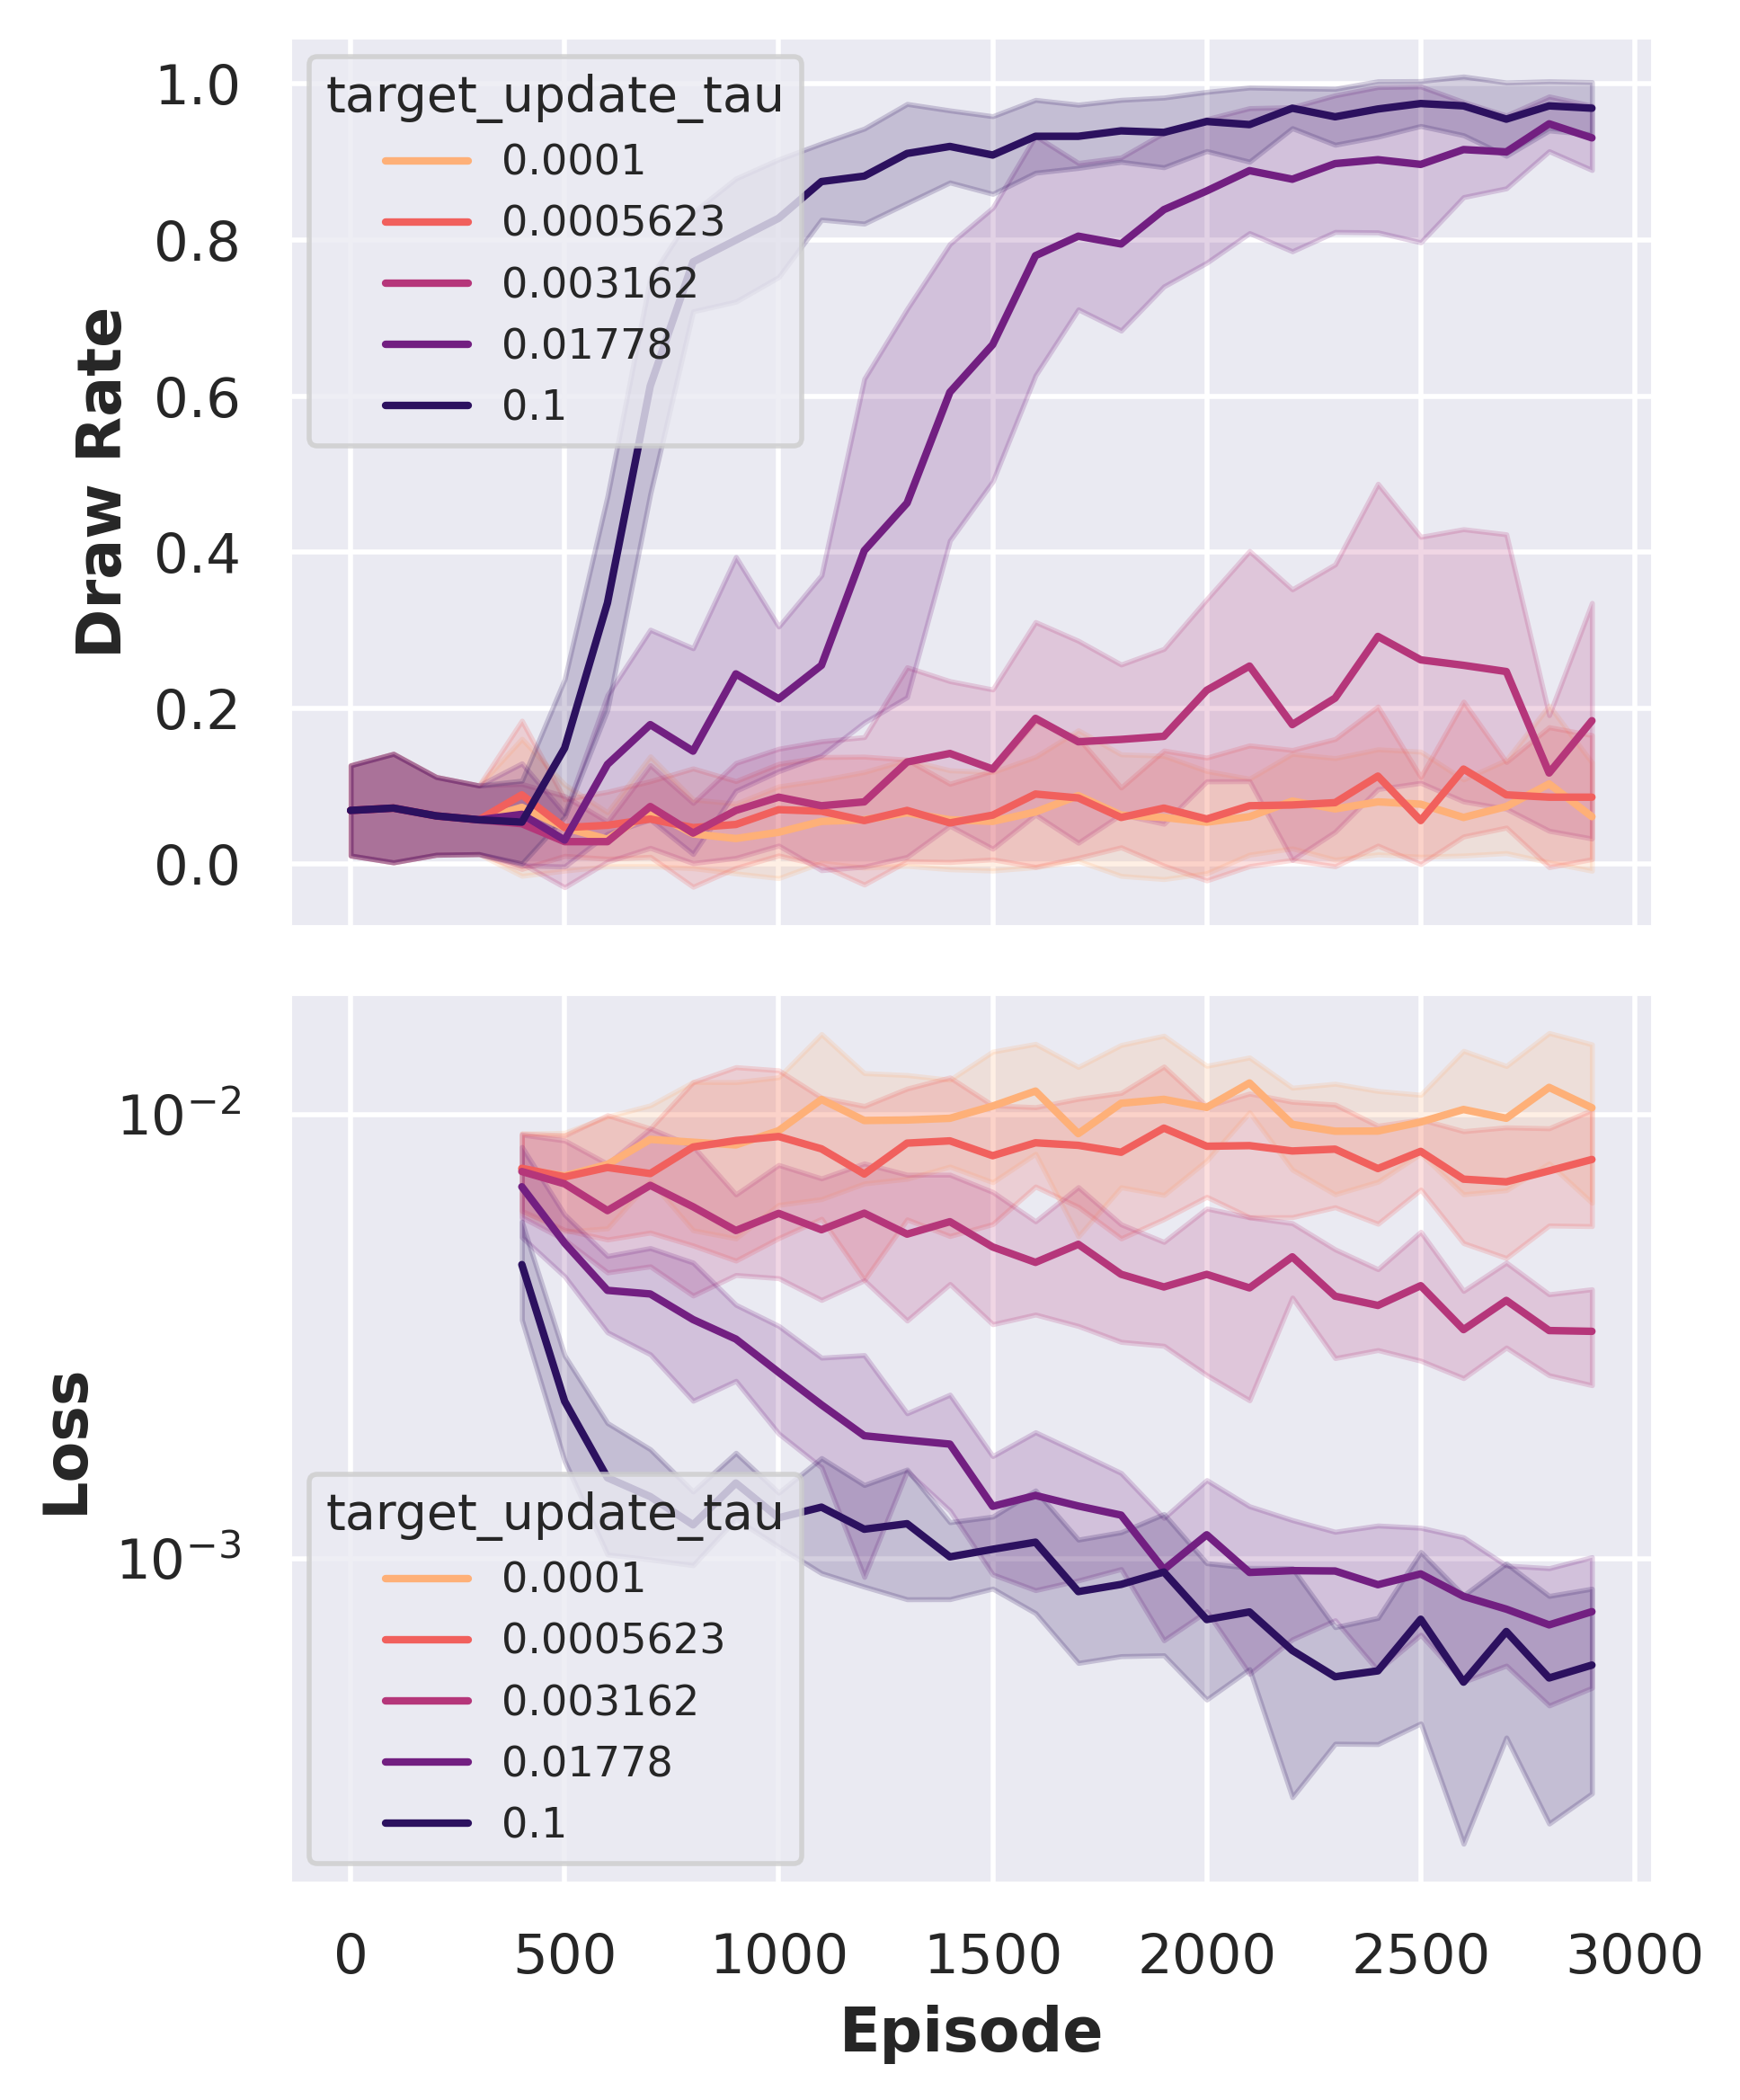

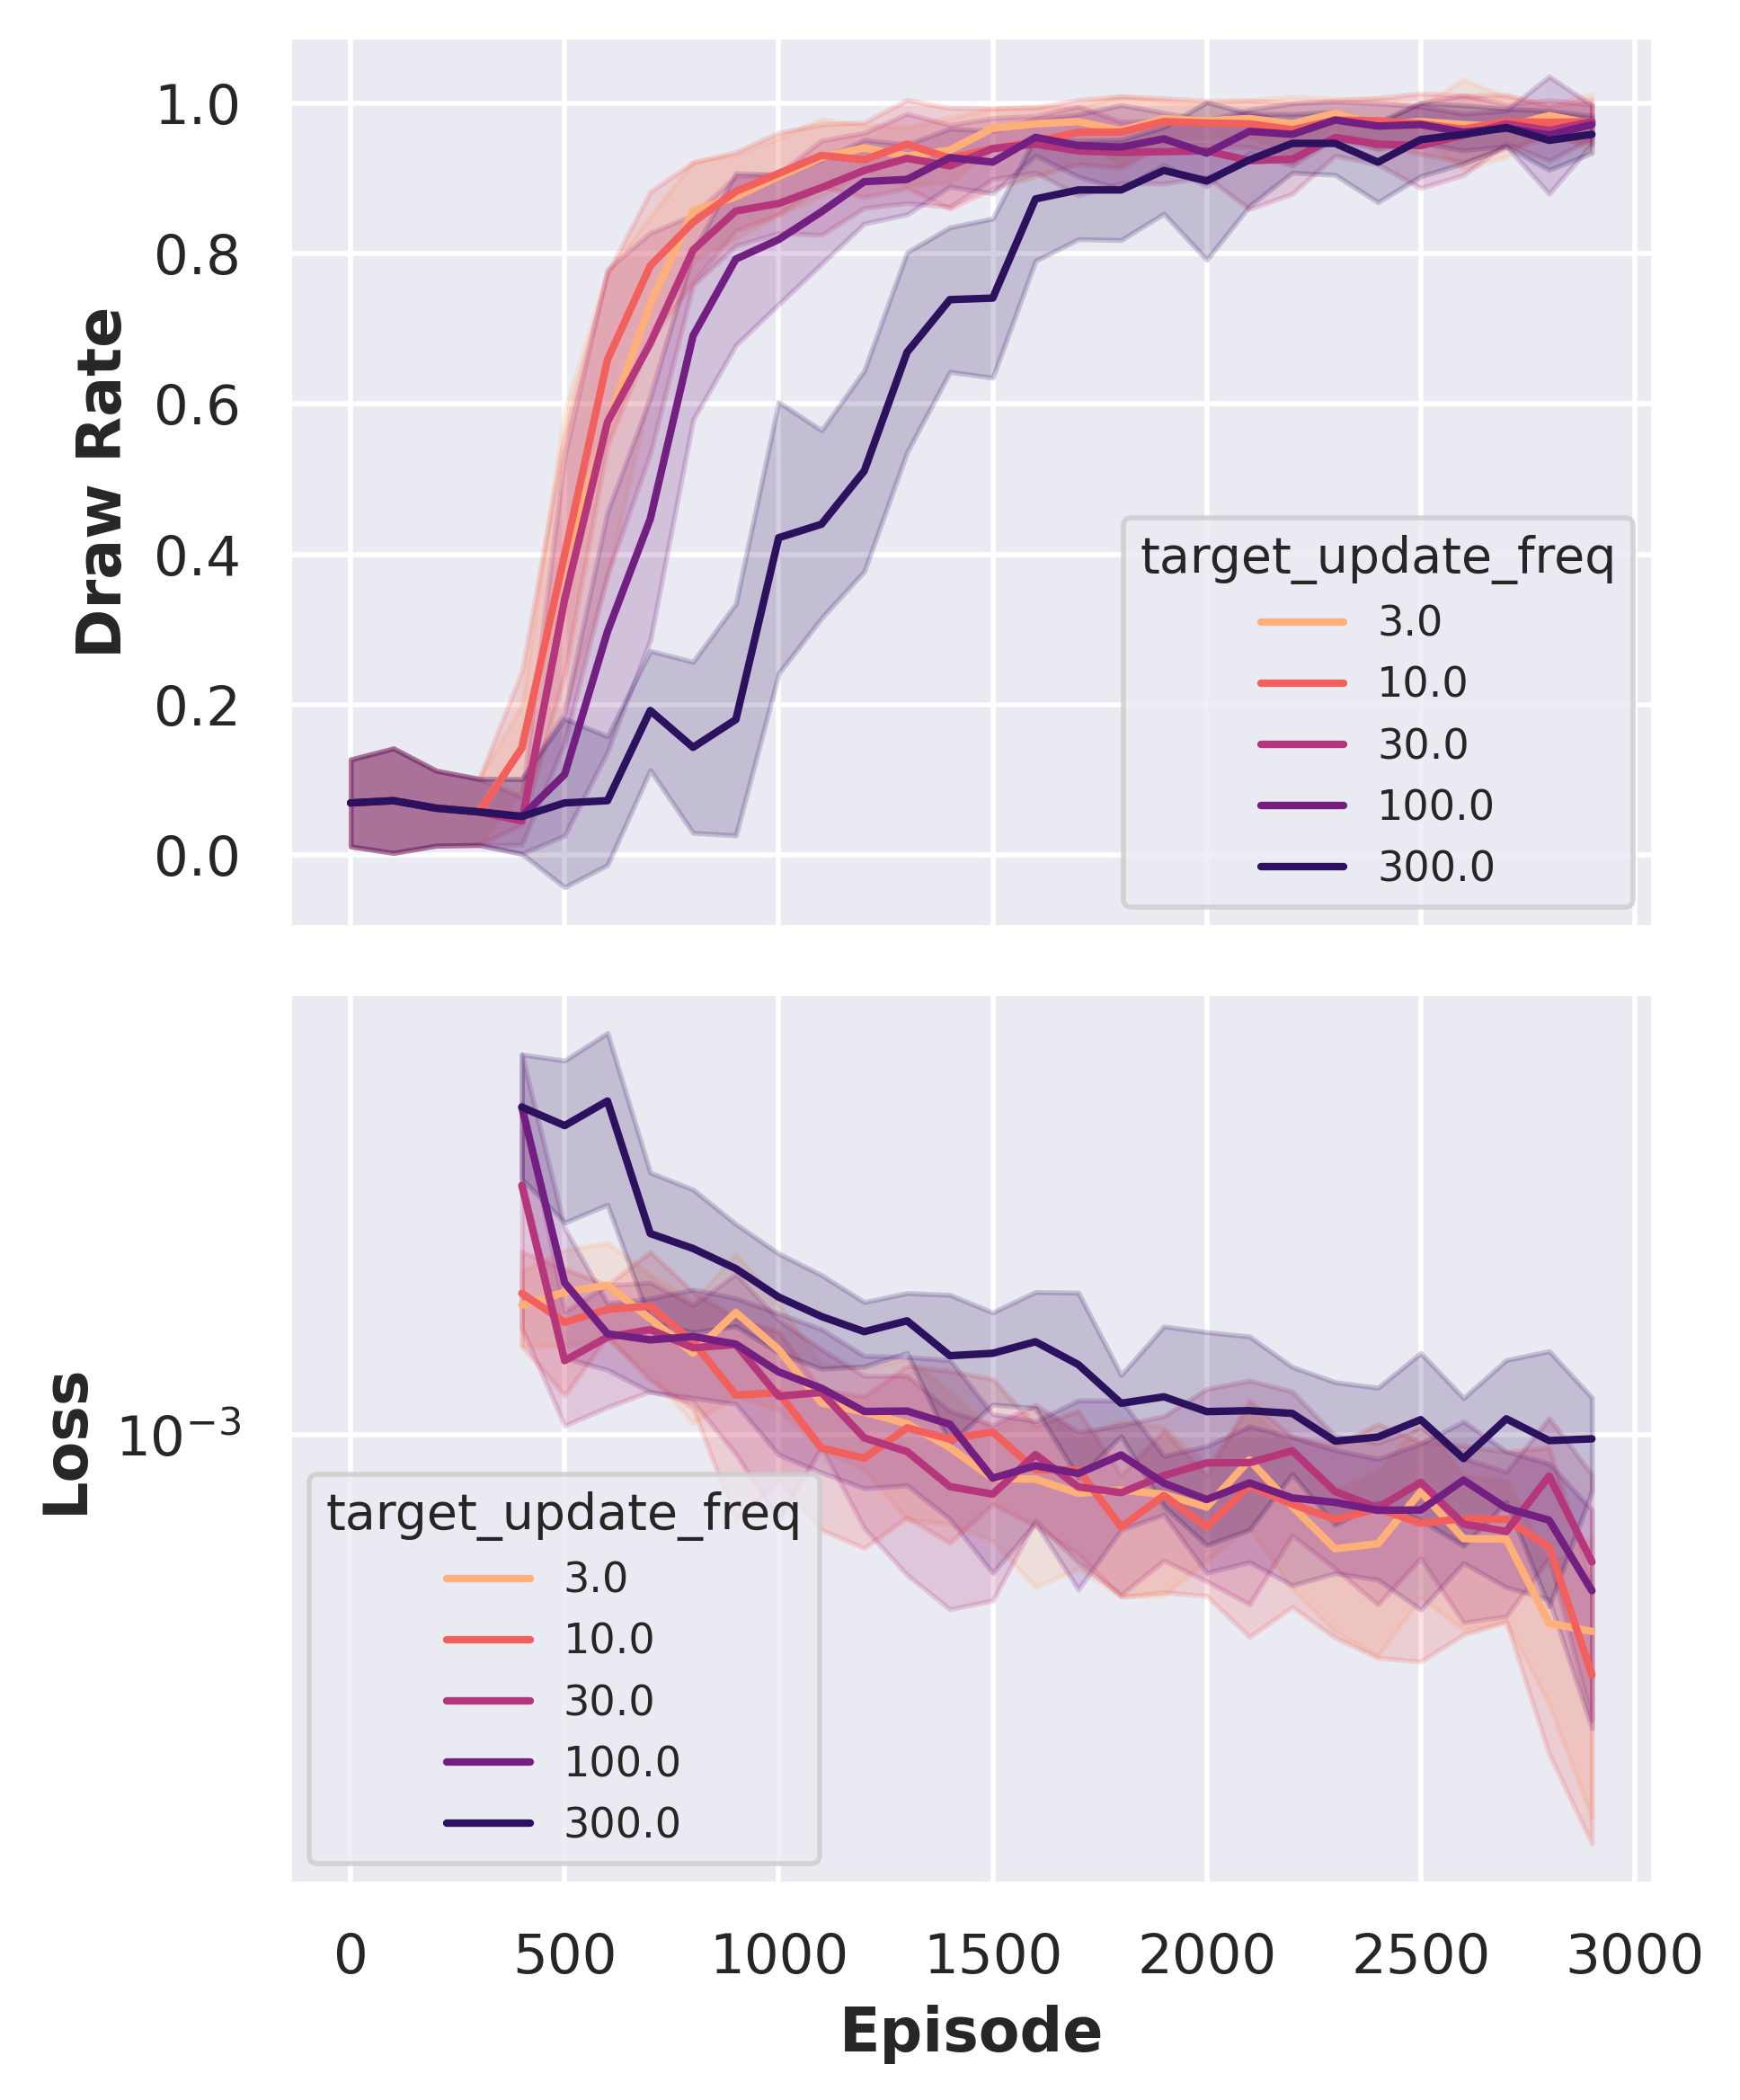

In [8]:
plot_ensemble("ensemble_runs", "target_update_tau",  target_network="double_dqn")
plot_ensemble("ensemble_runs", "target_update_freq", target_network="double_dqn")

## Figure 3: Duelling DQN performance

In [5]:


def build_dueling_dqn_model(input_shape, num_actions, hidden_layer_size):
    """
    Duelling DQN: Q(s,a) = V(s) + (A(s,a) - mean_a A(s,a))
    Both V and A heads are linear in the final layer.
    """
    inputs = layers.Input(shape=input_shape)

    # -------- shared trunk ----------
    x = layers.Dense(hidden_layer_size, activation='relu')(inputs)

    # -------- value stream ----------
    v = layers.Dense(hidden_layer_size, activation='relu')(x)
    v = layers.Dense(1,  activation='linear')(v)              # shape (None, 1)

    # -------- advantage stream ------
    a = layers.Dense(hidden_layer_size, activation='relu')(x)
    a = layers.Dense(num_actions, activation='linear')(a)     # shape (None, n_actions)

    # -------- aggregate -------------
    # Q(s,a) = V + (A - mean(A))
    def combine_v_a(inputs):
        v, a = inputs
        a_centered = a - tf.reduce_mean(a, axis=1, keepdims=True)
        return v + a_centered

    q = layers.Lambda(combine_v_a)([v, a])                # shape (None, n_actions)

    model = models.Model(inputs=inputs, outputs=q, name="DuellingDQN")
    return model

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 2999.40it/s] 


Initializing random MinMax agent 2


100%|██████████| 19683/19683 [00:06<00:00, 3056.95it/s] 


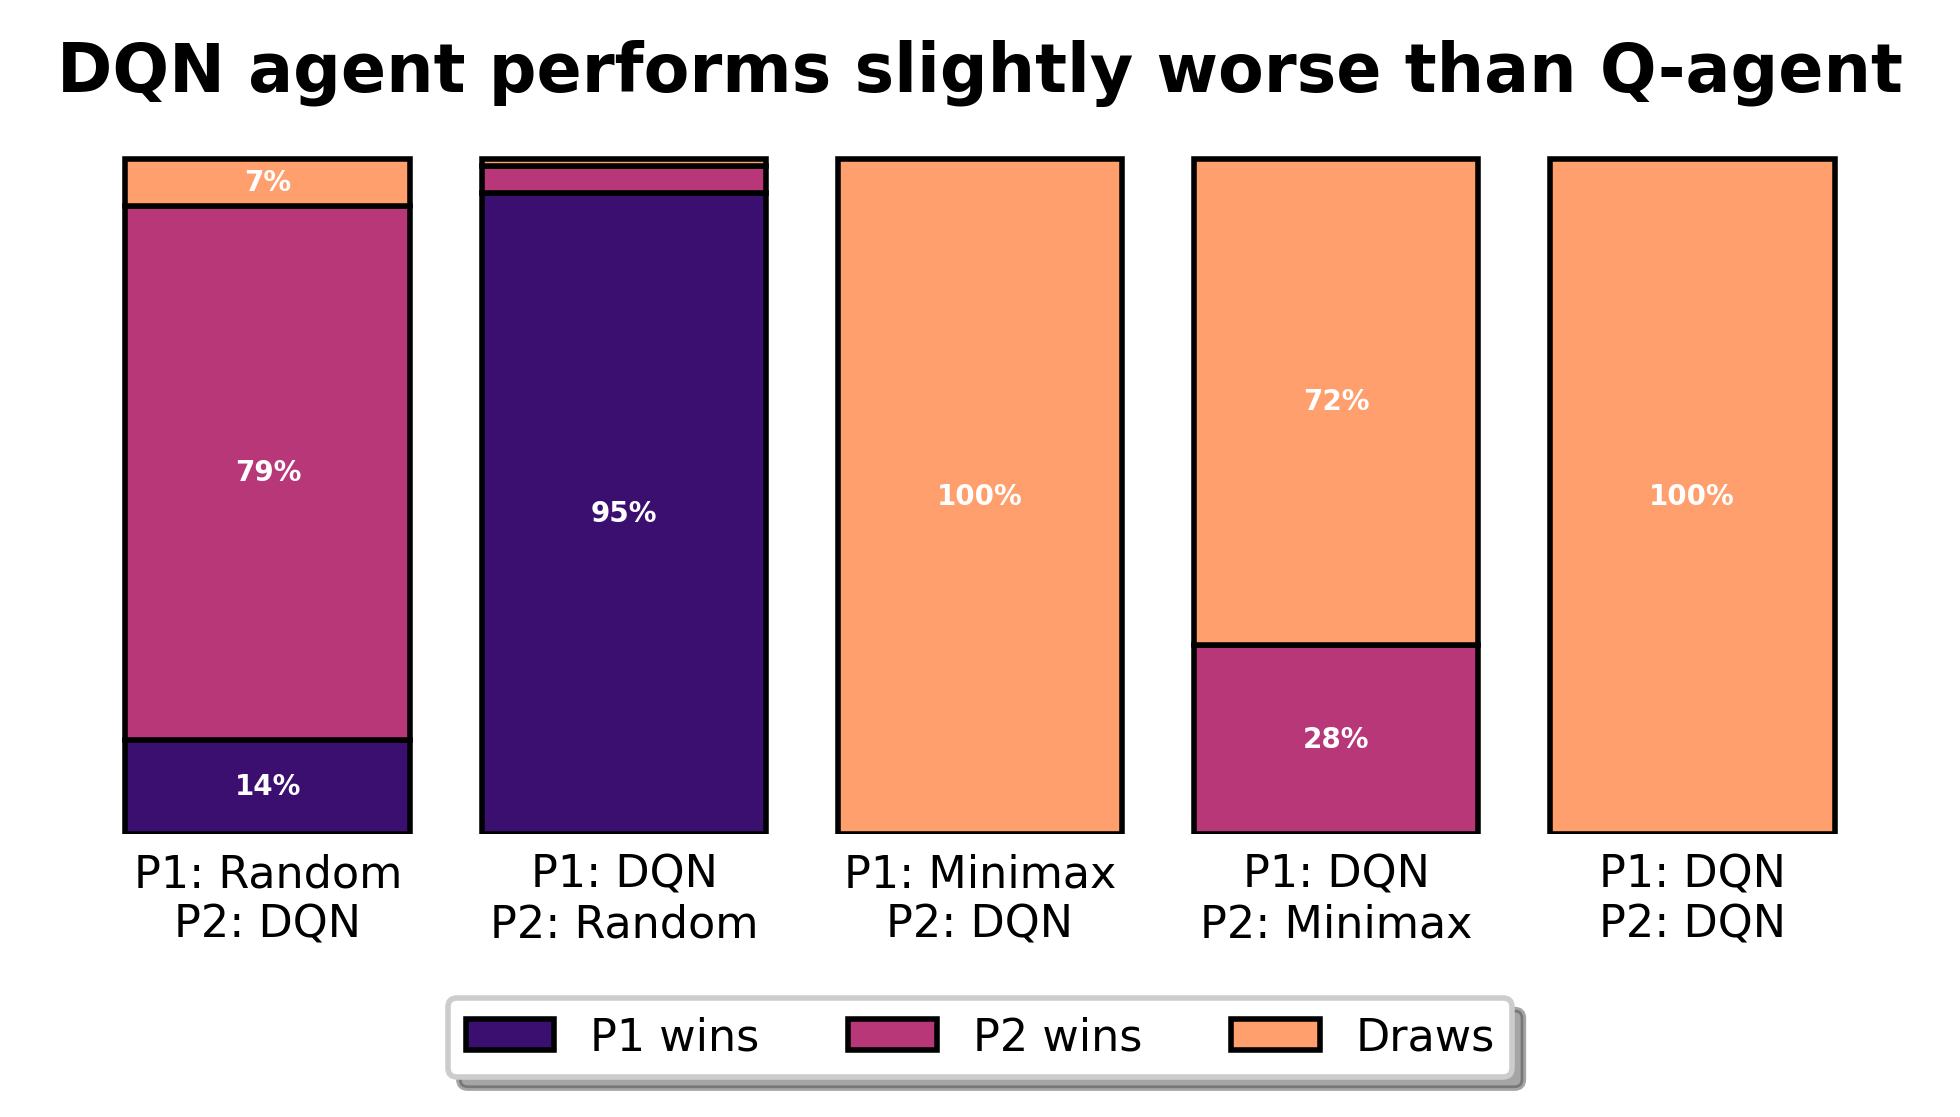

In [7]:

hidden_layer_size = 128

# Helper to initialize and compile a DQNAgent
def create_deepq_agent(agent_id, n_actions, n_states, config):
    agent = DeepQAgent(agent_id=agent_id, n_actions=n_actions, n_states=n_states, config=config)
    agent.online_model = build_dueling_dqn_model(agent.input_shape, agent.n_actions, hidden_layer_size=hidden_layer_size)
    agent.target_model = agent.online_model
    agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent.learning_rate), loss='mse')
    return agent

config = dict(base_config)

# Set up agent
runs = {}
n_actions = 9
n_states = 3**9  # e.g., Tic-Tac-Toe encoded in ternary
deepq_p1 = create_deepq_agent(1, n_actions, n_states, config)
deepq_p2 = create_deepq_agent(2, n_actions, n_states, config)

# Define benchmark runs
runs["random vs deepq"] = training_manager.run_training(config, [RandomAgent(1, n_actions), create_deepq_agent(2, n_actions, n_states, config)])
runs["deepq vs random"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), RandomAgent(2, n_actions)])
runs["minmax vs deepq"] = training_manager.run_training(config, [MinMaxAgent(1, n_actions, n_states, game, True), create_deepq_agent(2, n_actions, n_states, config)])
runs["deepq vs minmax"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), MinMaxAgent(2, n_actions, n_states, game, True)])
runs["deepq vs deepq"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), create_deepq_agent(2, n_actions, n_states, config)])

compare_training_runs(
    [
        runs["random vs deepq"],
        runs["deepq vs random"],
        runs["minmax vs deepq"],
        runs["deepq vs minmax"],
        runs["deepq vs deepq"]
    ],
    [
        "P1: Random\nP2: DQN",
        "P1: DQN\nP2: Random",
        "P1: Minimax\nP2: DQN",
        "P1: DQN\nP2: Minimax",
        "P1: DQN\nP2: DQN"
    ],
    colors=colors,
    labels=["P1 wins", "P2 wins", "Draws"],
    filename="figures/18_duelling_deepq_agent_comparison.png",
    title="DQN agent performs slightly worse than Q-agent"
)

## Figure 4: Duelling QDN network architecture sweep 

In [6]:
import os
import numpy as np
import pandas as pd

# Define your parameter sweep ranges
param_sweep = {
    "hidden_layer_size":  [8, 16, 32, 64, 128, 256],
}


agent1 = MinMaxAgent(1, ACTIONS, 3**9, game, True)


def make_agent_1(cfg: dict):
    return agent1

# Loop over each hyperparameter
for param_name, values in param_sweep.items():
    for value in values:


        # Build agent constructor with fixed layer size
        def make_agent_2(cfg: dict):
            ag = DeepQAgent(2, ACTIONS, STATES, cfg)
            net1 = build_dueling_dqn_model(ag.input_shape, ag.n_actions, hidden_layer_size=value)
            net1.compile(optimizer=tf.keras.optimizers.Adam(cfg["learning_rate"]), loss="mse")
            net2 = net1
            ag.online_model = net1
            ag.target_model = net2
            return ag

        # Clone and modify config
        cfg = dict(base_config)
        # Run ensemble
        df = run_ensemble(make_agent_1, make_agent_2, base_config=cfg)

        # Save results
        filename = f"ensemble_runs/minmax_vs_duelling_dqn_{param_name}_{value:.4g}.csv"
        df.to_csv(filename, index=False)
        print(f"✔ Saved: {filename}")


Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 3087.41it/s] 


✔ Saved: ensemble_runs/minmax_vs_duelling_dqn_hidden_layer_size_8.csv
✔ Saved: ensemble_runs/minmax_vs_duelling_dqn_hidden_layer_size_16.csv
✔ Saved: ensemble_runs/minmax_vs_duelling_dqn_hidden_layer_size_32.csv
✔ Saved: ensemble_runs/minmax_vs_duelling_dqn_hidden_layer_size_64.csv
✔ Saved: ensemble_runs/minmax_vs_duelling_dqn_hidden_layer_size_128.csv
✔ Saved: ensemble_runs/minmax_vs_duelling_dqn_hidden_layer_size_256.csv


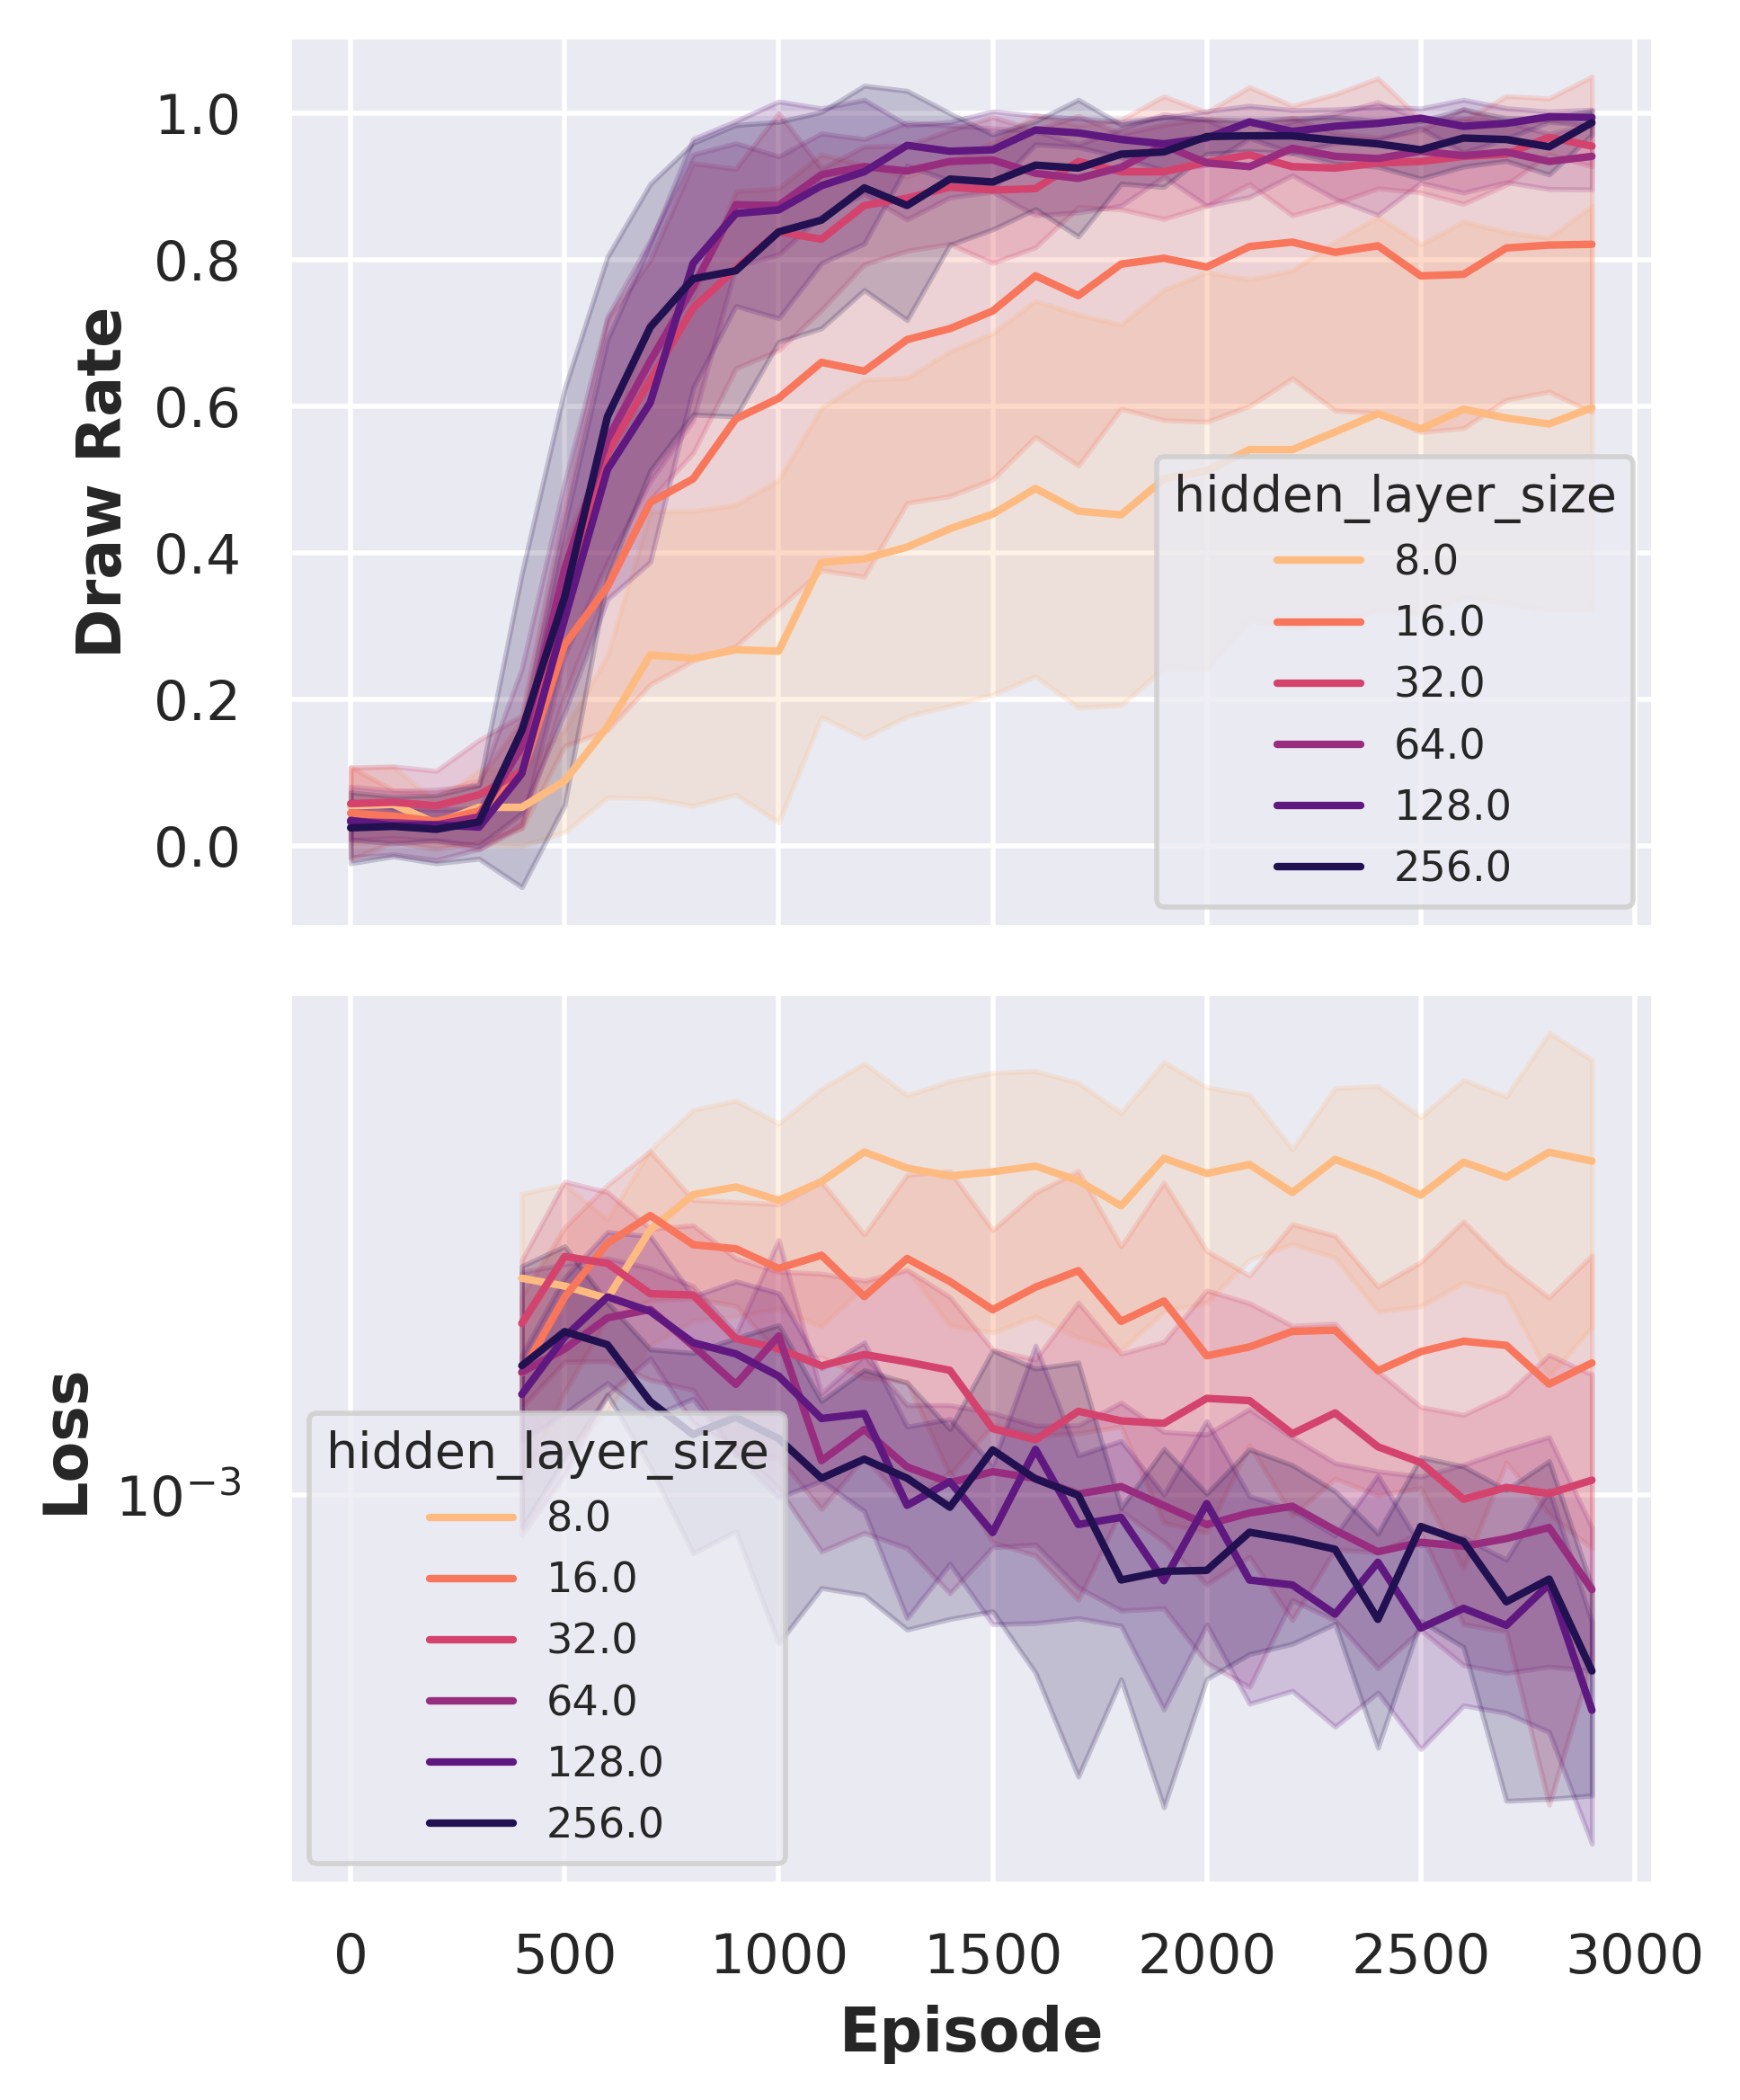

In [9]:
plot_ensemble("ensemble_runs", "hidden_layer_size", target_network="duelling_dqn")

## 1. Why Prioritized Replay?

In standard (uniform) replay, every past transition $(s,a,r,s′)(s,a,r,s′)$ is equally likely to be sampled for training. But not all transitions are equally “useful”:

- A transition where your network’s Q-estimate is very wrong (large temporal-difference error) carries more learning signal than one it already predicts well.

- PER biases sampling toward high-error transitions, so your agent spends more gradient updates where it can learn most.

However, that bias creates sampling bias, which we must correct via importance-sampling weights (more on that below).


## 2. The Sum-Tree: fast priority sampling

We need two operations, repeatedly, on our buffer of size NN:

- Sample an index $i$ with probability
$$P(i)  =  \frac{p^a_i}{\sum^N_{j=1}p_j^a}$$
where $p_i$​ is the priority of transition $i$ (typically $abs(\delta_i)  + \epsilon)$).

- Update the priority pipi​ when δiδi​ changes.

- A flat array of priorities would let you update in $\mathcal{O}(1)$, but sampling in $\mathcal{O}(N)$ (you’d have to do a cumulative-sum search). A binary SumTree gives you:

- $\mathcal{O}(\log N)$ update: walk from leaf to root, updating parent sums.

- $\mathcal{O}(\log N)$ sample: pick a random number $x∈[0,∑jpj]$ and descend the tree comparing to left/right child sums.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from src.agent_deep_q import PrioritisedDeepQAgent as DeepQAgent
from src.agent_random import RandomAgent
from src.agent_minmax import MinMaxAgent

# Q-network factory
def build_simple_dqn_model(input_shape, num_actions, num_hidden_layers=1, hidden_layer_size=64):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_layer_size, activation='relu')(x)
    outputs = layers.Dense(num_actions, activation='linear')(x)
    return models.Model(inputs=inputs, outputs=outputs)

# Config
config = dict(base_config)
config.update({
    "n_eval": 100,    # Number of evaluation episodes every eval_freq training episodes
    "eval_freq"  : 100,
})

# Helper to initialize and compile a DQNAgent
def create_deepq_agent(agent_id, n_actions, n_states, config):
    agent = DeepQAgent(agent_id=agent_id, n_actions=n_actions, n_states=n_states, config=config)
    agent.online_model = build_simple_dqn_model(agent.input_shape, agent.n_actions)
    agent.target_model = agent.online_model
    agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=agent.learning_rate), loss='mse')
    return agent

# Set up agent
runs = {}
n_actions = 9
n_states = 3**9  # e.g., Tic-Tac-Toe encoded in ternary
deepq_p1 = create_deepq_agent(1, n_actions, n_states, config)
deepq_p2 = create_deepq_agent(2, n_actions, n_states, config)

# Define benchmark runs
runs["random vs deepq"] = training_manager.run_training(config, [RandomAgent(1, n_actions), create_deepq_agent(2, n_actions, n_states, config)])
runs["deepq vs random"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), RandomAgent(2, n_actions)])
runs["minmax vs deepq"] = training_manager.run_training(config, [MinMaxAgent(1, n_actions, n_states, game, True), create_deepq_agent(2, n_actions, n_states, config)])
runs["deepq vs minmax"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), MinMaxAgent(2, n_actions, n_states, game, True)])
runs["deepq vs deepq"] = training_manager.run_training(config, [create_deepq_agent(1, n_actions, n_states, config), create_deepq_agent(2, n_actions, n_states, config)])


100%|██████████| 3000/3000 [02:41<00:00, 18.52it/s]


Initializing random MinMax agent 1


100%|██████████| 3000/3000 [02:09<00:00, 23.13it/s]


Initializing random MinMax agent 2


100%|██████████| 3000/3000 [04:29<00:00, 11.11it/s]


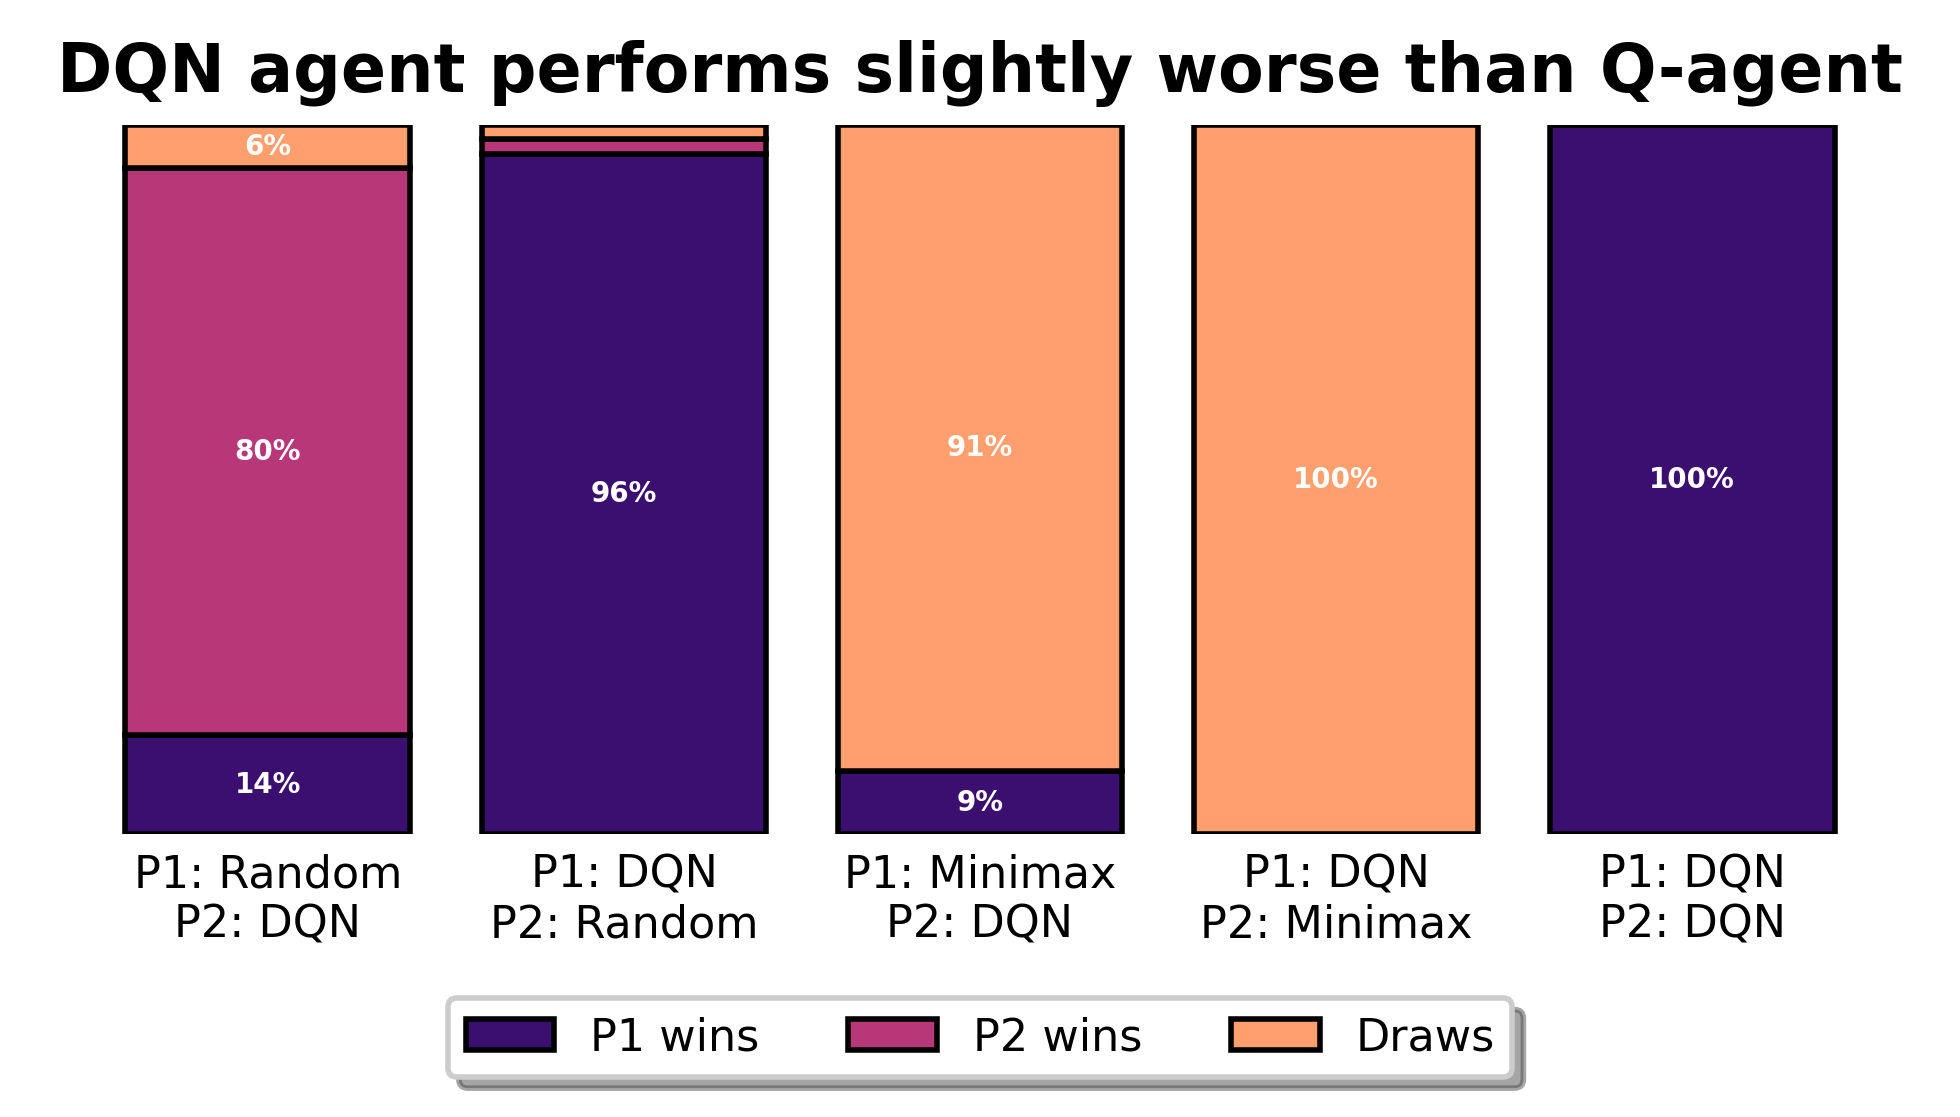

In [11]:

compare_training_runs(
    [
        runs["random vs deepq"],
        runs["deepq vs random"],
        runs["minmax vs deepq"],
        runs["deepq vs minmax"],
        runs["deepq vs deepq"]
    ],
    [
        "P1: Random\nP2: DQN",
        "P1: DQN\nP2: Random",
        "P1: Minimax\nP2: DQN",
        "P1: DQN\nP2: Minimax",
        "P1: DQN\nP2: DQN"
    ],
    colors=colors,
    labels=["P1 wins", "P2 wins", "Draws"],
    filename="bak.png",
    title="DQN agent performs slightly worse than Q-agent"
)